## 1. Create session and read data

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('mysparkapp').getOrCreate()
spark

In [ ]:
dataset_path = "/content/drive/MyDrive/Data/Delhi house data.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [ ]:
df.show(10)

+------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+--------+
|  Area|BHK|Bathroom|    Furnishing|            Locality|Parking|   Price|       Status| Transaction|         Type|Per_Sqft|
+------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+--------+
| 800.0|  3|       2|Semi-Furnished|    Rohini Sector 25|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|    null|
| 750.0|  2|       2|Semi-Furnished|J R Designers Flo...|      1| 5000000|Ready_to_move|New_Property|    Apartment|    6667|
| 950.0|  2|       2|     Furnished|Citizen Apartment...|      1|15500000|Ready_to_move|      Resale|    Apartment|    6667|
| 600.0|  2|       2|Semi-Furnished|    Rohini Sector 24|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|    6667|
| 650.0|  2|       2|Semi-Furnished|Rohini Sector 24 ...|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|    6667|


In [ ]:
print('Number of rows: ', df.count())
print('Columns: ', df.columns)
print('Number of columns: ', len(df.columns))

Number of rows:  1259
Columns:  ['Area', 'BHK', 'Bathroom', 'Furnishing', 'Locality', 'Parking', 'Price', 'Status', 'Transaction', 'Type', 'Per_Sqft']
Number of columns:  11


In [ ]:
df.printSchema()

root
 |-- Area: double (nullable = true)
 |-- BHK: integer (nullable = true)
 |-- Bathroom: integer (nullable = true)
 |-- Furnishing: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- Parking: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Transaction: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Per_Sqft: integer (nullable = true)



## 2.Data cleaning

In [ ]:
from pyspark.sql.functions import col,isnan,when,count,udf,mean
from pyspark.sql.types import StringType, IntegerType, FloatType

### 2.1. Process NULL values

First we count the number of NULL values in the dataset

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+
|Area|BHK|Bathroom|Furnishing|Locality|Parking|Price|Status|Transaction|Type|Per_Sqft|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+
|   0|  0|       2|         5|       0|     33|    0|     0|          0|   5|     241|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+--------+



As there are too many NULL values in the Per_sqft column (241 rows compared to 1259 total sample size), also the meaning of this column is unclear, we will remove this column

In [ ]:
df = df.drop('Per_sqft')
df.show(5)

+-----+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+
| Area|BHK|Bathroom|    Furnishing|            Locality|Parking|   Price|       Status| Transaction|         Type|
+-----+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+
|800.0|  3|       2|Semi-Furnished|    Rohini Sector 25|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|
|750.0|  2|       2|Semi-Furnished|J R Designers Flo...|      1| 5000000|Ready_to_move|New_Property|    Apartment|
|950.0|  2|       2|     Furnished|Citizen Apartment...|      1|15500000|Ready_to_move|      Resale|    Apartment|
|600.0|  2|       2|Semi-Furnished|    Rohini Sector 24|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|
|650.0|  2|       2|Semi-Furnished|Rohini Sector 24 ...|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|
+-----+---+--------+--------------+--------------------+-------+--------+-------

The number of NULL values for columns location and size is insignificant, we can remove them

In [ ]:
df = df.dropna('any', subset=['Bathroom', 'Furnishing', 'Type'])

The column Parking has 33 NULL values, removing all the rows can lead to considearble data loss, a better solution is to replace the NULL cells with mean of all other Parking values

In [ ]:
mean_parking = round(df.select(mean(df['parking'])).collect()[0][0])
df = df.fillna(mean_parking, 'Parking')
print(mean_parking)

2


In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+--------+----------+--------+-------+-----+------+-----------+----+
|Area|BHK|Bathroom|Furnishing|Locality|Parking|Price|Status|Transaction|Type|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+
|   0|  0|       0|         0|       0|      0|    0|     0|          0|   0|
+----+---+--------+----------+--------+-------+-----+------+-----------+----+



Now the dataframe is left with no NULL values


### 2.2. Remove outliers

Outliers can effect the analysis results.

In [ ]:
df.show()

+--------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+
|    Area|BHK|Bathroom|    Furnishing|            Locality|Parking|   Price|       Status| Transaction|         Type|
+--------+---+--------+--------------+--------------------+-------+--------+-------------+------------+-------------+
|   800.0|  3|       2|Semi-Furnished|    Rohini Sector 25|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|
|   750.0|  2|       2|Semi-Furnished|J R Designers Flo...|      1| 5000000|Ready_to_move|New_Property|    Apartment|
|   950.0|  2|       2|     Furnished|Citizen Apartment...|      1|15500000|Ready_to_move|      Resale|    Apartment|
|   600.0|  2|       2|Semi-Furnished|    Rohini Sector 24|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|
|   650.0|  2|       2|Semi-Furnished|Rohini Sector 24 ...|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|
|  1300.0|  4|       3|Semi-Furnished|    Rohini Sector 

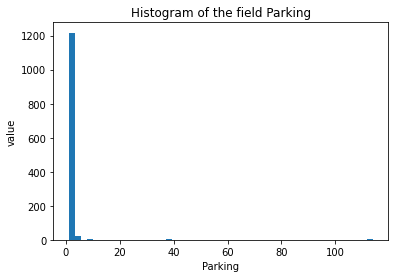

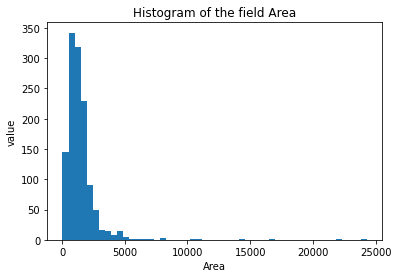

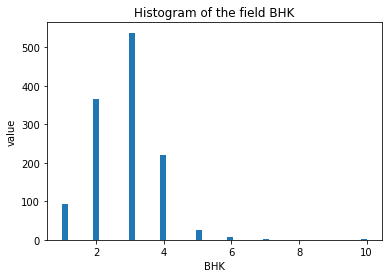

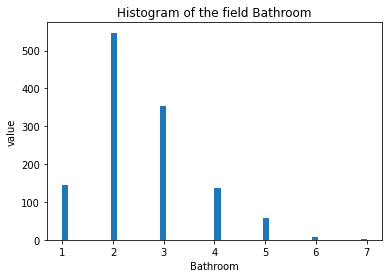

In [ ]:
import matplotlib.pyplot as plt
#For numeric values, we first have to plot the histogram to examime the distribution of these field
for field in ['Parking','Area','BHK','Bathroom']:
  arr = df.toPandas()[field]
  plt.hist(arr,bins = 50)
  plt.xlabel(field)
  plt.ylabel('value')
  plt.title(f'Histogram of the field {field}')
  plt.show()

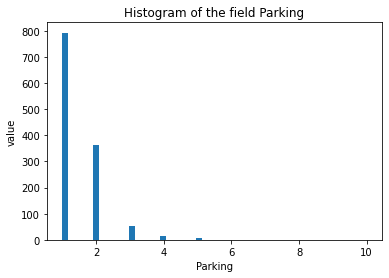

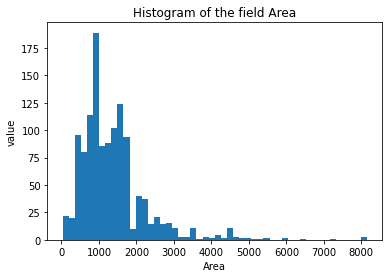

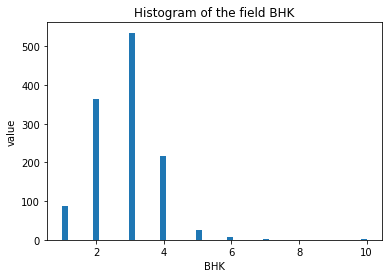

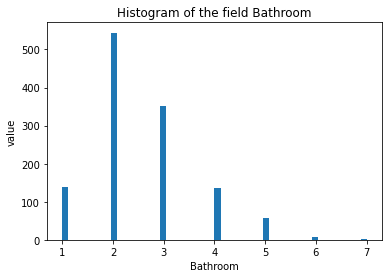

In [ ]:
#after examining the distribution of the numerical value, we then cut off some of the outliners
df = df.filter((df['Parking']<=10) & (df['Area']<=10000))
for field in ['Parking','Area','BHK','Bathroom']:
  arr = df.toPandas()[field]
  plt.hist(arr,bins = 50)
  plt.xlabel(field)
  plt.ylabel('value')
  plt.title(f'Histogram of the field {field}')
  plt.show()

 ### 2.3. Process categorical data

The four categorical columns furnishing, status, transaction, type are quite clean and dont need futher processing

In [ ]:
df.groupby('Furnishing').count().show()
df.groupby('Status').count().show()
df.groupby('Transaction').count().show()
df.groupby('Type').count().show()

+--------------+-----+
|    Furnishing|count|
+--------------+-----+
|Semi-Furnished|  700|
|     Furnished|  183|
|   Unfurnished|  352|
+--------------+-----+

+-------------+-----+
|       Status|count|
+-------------+-----+
|Ready_to_move| 1162|
| Almost_ready|   73|
+-------------+-----+

+------------+-----+
| Transaction|count|
+------------+-----+
|      Resale|  764|
|New_Property|  471|
+------------+-----+

+-------------+-----+
|         Type|count|
+-------------+-----+
|    Apartment|  580|
|Builder_Floor|  655|
+-------------+-----+



However, the column Location has too many categories, some of them has only 1-2 samples in the whole dataset. This can can affect the analysis process as we move to the next stages.

In [ ]:
grouped_locality = df.groupby('Locality').count().orderBy('Locality')
print('Number of categories: ', len(grouped_locality.collect()) )
grouped_locality.show()

Number of categories:  361
+--------------------+-----+
|            Locality|count|
+--------------------+-----+
|APL Builder Floor...|    2|
|Aashirwaad Chowk,...|    6|
|Abhimanyu Apartme...|    2|
|Abul Fazal Enclav...|    3|
|Abul Fazal Enclav...|    3|
|Adarsh Homes, Dwa...|    3|
|Ahinsha Vatika, R...|    1|
|           Alaknanda|   20|
|Amar Colony, Lajp...|    2|
|Andheria Mor, Meh...|    3|
|Anekant Apartment...|    1|
|Anupam Enclave, S...|    1|
|Apna Apartments, ...|    1|
|Aravali Apartment...|    4|
|Aravali Tower, Ch...|    1|
|Archana Apartment...|    1|
|Arjun Nagar, Safd...|    5|
|Arya Chittaranjan...|    1|
|Ashirwad Apartmen...|    2|
|Ashirwad Apartmen...|    3|
+--------------------+-----+
only showing top 20 rows



As can be seen from the summary table above, some of the localities belong to the same larger district/area, we will group each group of similar localities to a larger category. Therefore we can have a smaller number of categories

In [ ]:
def filterLocation(location):
    if len(location) > 100:
        return location
    
    filtered_area = location.rsplit(',',1)[-1].strip()
    
    # filter out unnecessary information for classifying location
    tokens = filtered_area.rsplit(' ', 1)
    if len(tokens) > 1 and tokens[-1].isdigit():
        filtered_area = tokens[0]
    
    pos = filtered_area.find('Sector')
    pos = filtered_area.find('Phase') if pos == -1 else pos
    pos = filtered_area.find('Block') if pos == -1 else pos
    pos = filtered_area.find('Pocket') if pos == -1 else pos
    
    if pos >= 0:
        filtered_area = filtered_area[:pos]
    
    return filtered_area.strip()

In [ ]:
locality_convert = udf(filterLocation, StringType())
df = df.withColumn('filtered_locality', locality_convert(df.Locality))

In [ ]:
filtered_locations = set()
for x in df.collect():
    if len(x['filtered_locality']) < 100:
        filtered_locations.add(x['filtered_locality'])

def filterLocation2(locations):
    def filterLongLocation(x):
        if len(x) < 100:
            return x
        for location in locations:
            if x.find(location) != -1:
                return location
        return x
    return udf(filterLongLocation)

In [ ]:
df = df.withColumn('filtered_locality', filterLocation2(filtered_locations)('filtered_locality'))

In [ ]:
minor_rows = df.groupby('filtered_locality').count().filter(col('count') < 5)
minor_categories = [row['filtered_locality'] for row in minor_rows.collect()]
df = df.withColumn('filtered_locality', udf(lambda x: 'others 'if x in minor_categories else x)('filtered_locality'))

In [ ]:
df = df.drop('Locality')
df = df.withColumnRenamed('filtered_locality', 'Locality')

After the filtering process, the column Locality is left with 42 categories, a huge optimization. We also grouped all the low frequency categories to the same group, named "others"

In [ ]:
grouped_locality = df.groupby('Locality').count().orderBy('Locality')
print('Number of categories: ', len(grouped_locality.collect()) )
grouped_locality.show()

Number of categories:  42
+--------------------+-----+
|            Locality|count|
+--------------------+-----+
|           Alaknanda|   56|
|          Budh Vihar|   18|
|         Chhattarpur|   22|
| Chhattarpur Enclave|    8|
|   Chittaranjan Park|   27|
|Commonwealth Game...|   28|
|      Dilshad Garden|   30|
|              Dwarka|   74|
|          Dwarka Mor|   13|
|        Geeta Colony|    5|
|     Greater Kailash|   40|
|           Hauz Khas|   30|
|             Kalkaji|   28|
|          Karol Bagh|   32|
|         Kirti Nagar|   28|
|        Lajpat Nagar|   88|
|         Laxmi Nagar|   34|
|     Mahavir Enclave|   13|
|Mahavir Enclave Part|   17|
|       Malviya Nagar|   30|
+--------------------+-----+
only showing top 20 rows



## 3. Exploratory data analysis

In [ ]:
df.show(5)

+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
| Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|
+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
|800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|
|950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|
|600.0|  2|       2|Semi-Furnished|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|  Rohini|
|650.0|  2|       2|Semi-Furnished|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
only showing top 5 rows



In [ ]:
#For categorical data, first, we have to see number of distinct values in a specific field
for field in ['Furnishing', 'Status', 'Transaction', 'Type', 'Locality']:
  n = df.select(field).distinct().count()
  print(f'Field: {field} \nNumber of unique values: {n}\n\n')

Field: Furnishing 
Number of unique values: 3


Field: Status 
Number of unique values: 2


Field: Transaction 
Number of unique values: 2


Field: Type 
Number of unique values: 2


Field: Locality 
Number of unique values: 42




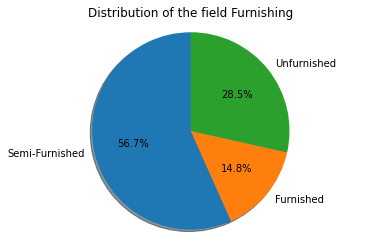

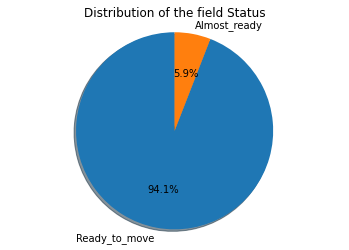

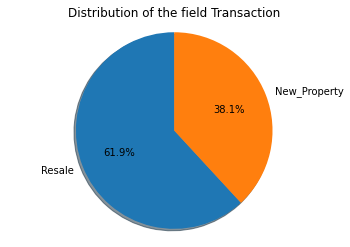

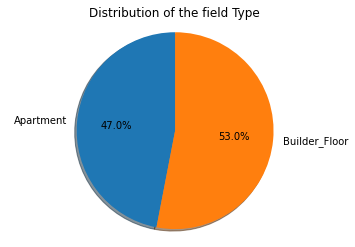

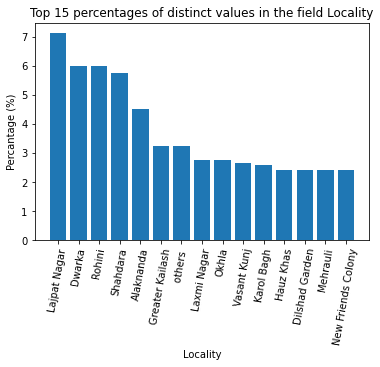

In [ ]:
#plot distribution of categorical fields

import matplotlib.pyplot as plt
# first, we draw pie chart for the two field area_type, availability
for field in ['Furnishing', 'Status', 'Transaction', 'Type']:
  labels = df.groupBy(field).count().rdd.map(lambda x: x[0]).collect()
  sizes = df.groupBy(field).count().rdd.map(lambda x: x[1]).collect()

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  plt.title(f'Distribution of the field {field}')
  plt.show()

# as the field location has too many distinct value (>1200 distinct value), it is more appropriate to draw a barchar here:
labels = df.groupBy('Locality').count().sort(col('count').desc()).rdd.map(lambda x: x[0]).collect()
sizes = df.groupBy('Locality').count().sort(col('count').desc()).rdd.map(lambda x: x[1]).collect()
n_cols = df.count()
sizes = [ x/n_cols*100 for x in sizes]

plt.bar(labels[:15], sizes[:15])
plt.ylabel('Percantage (%)')
plt.xlabel('Locality')
plt.title('Top 15 percentages of distinct values in the field Locality')
plt.xticks(rotation=80)
plt.show()

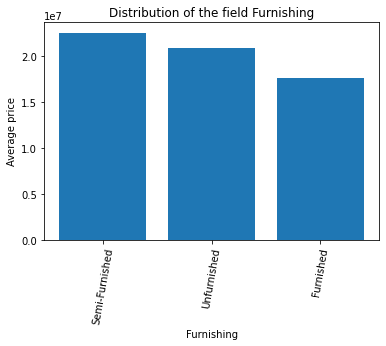

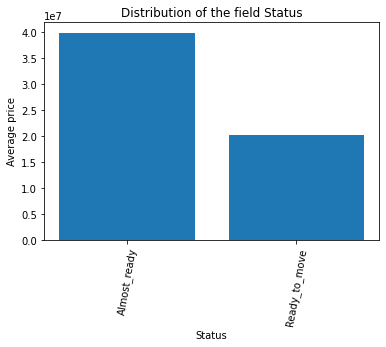

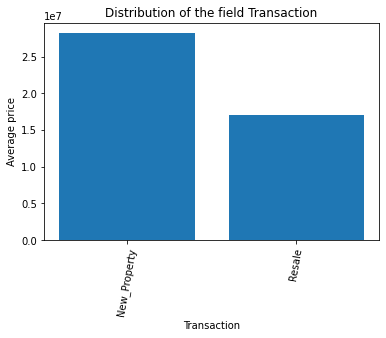

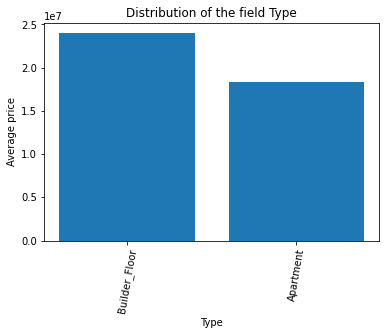

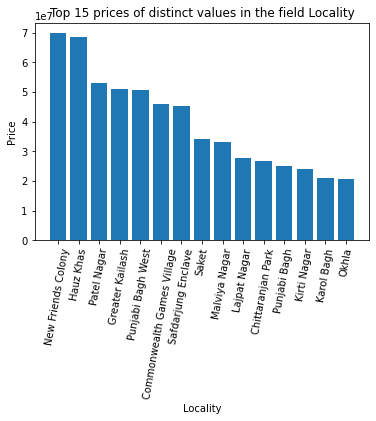

In [ ]:
#Then, we compare the avarage house price between categories
import matplotlib.pyplot as plt
# first, we draw pie chart for the two field area_type, availability
for field in ['Furnishing', 'Status', 'Transaction', 'Type']:
  labels = df.groupBy(field).mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[0]).collect()
  sizes = df.groupBy(field).mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[5]).collect()

  plt.bar(labels, sizes)
  plt.ylabel('Average price')
  plt.xlabel(field)
  plt.title(f'Average prices between distinct values in the field {field}')
  plt.xticks(rotation=80)
  plt.title(f'Distribution of the field {field}')
  plt.show()

labels = df.groupBy('Locality').mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[0]).collect()
sizes = df.groupBy('Locality').mean().sort(col('avg(price)').desc()).rdd.map(lambda x: x[5]).collect()

plt.bar(labels[:15], sizes[:15])
plt.ylabel('Price')
plt.xlabel('Locality')
plt.title('Top 15 prices of distinct values in the field Locality')
plt.xticks(rotation=80)
plt.show()

In [ ]:
df.show(2)

+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
| Area|BHK|Bathroom|    Furnishing|Parking|  Price|       Status| Transaction|         Type|Locality|
+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
|800.0|  3|       2|Semi-Furnished|      1|6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|750.0|  2|       2|Semi-Furnished|      1|5000000|Ready_to_move|New_Property|    Apartment|  Rohini|
+-----+---+--------+--------------+-------+-------+-------------+------------+-------------+--------+
only showing top 2 rows



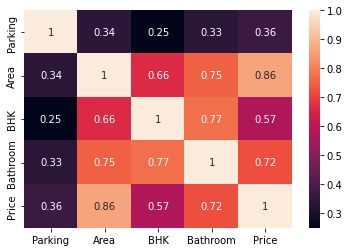

In [ ]:
# As we have seen the distribution of each numeric column in the previous section, we now will examine the corollation between numeric field to each other
import seaborn as sns
import numpy as np
confusion_matrix = []
for field1 in ['Parking','Area','BHK','Bathroom', 'Price']:
  confusion_matrix_row = []
  for field2 in ['Parking','Area','BHK','Bathroom', 'Price']:
    x = df.select(field2).rdd.flatMap(lambda x: x).collect()
    y = df.select(field1).rdd.flatMap(lambda x: x).collect()
    confusion_matrix_row.append(np.corrcoef(x, y)[0][1])
  confusion_matrix.append(confusion_matrix_row)
confusion_matrix = np.array(confusion_matrix)
ax = sns.heatmap(confusion_matrix, annot=True, xticklabels = ['Parking','Area','BHK','Bathroom', 'Price'], yticklabels = ['Parking','Area','BHK','Bathroom', 'Price'])  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99be227a50>,
      dtype=object)

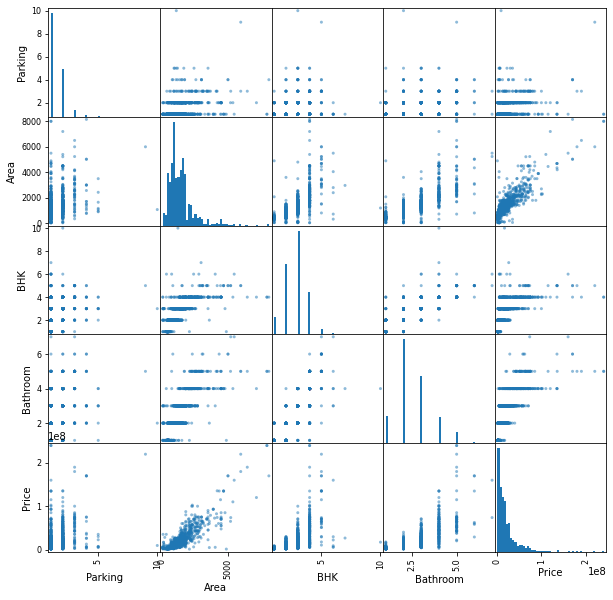

In [ ]:
import pandas as pd
# to be more clear, 
pd.plotting.scatter_matrix(df.toPandas()[['Parking','Area','BHK','Bathroom', 'Price']], hist_kwds={'bins':50}, figsize = (10,10))

## 4. Pyspark ML Lib

In this part, we will build some models to predict house price from other information. The first step is to extract features that can be 
used to fit the prediction models, from the columns

### 4.1. Feature extraction

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, MinMaxScaler, VectorAssembler

In [ ]:
df.show(20)

+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
|    Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|
+--------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+
|   800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|   750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|
|   950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|
|   600.0|  2|       2|Semi-Furnished|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|  Rohini|
|   650.0|  2|       2|Semi-Furnished|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|  1300.0|  4|       3|Semi-Furnished|      1|15500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|
|  1350.0|  4|       3|Semi-Furnished|      1|

There are 2 steps to process categorical data.
1. Transform strings to indexes.
2. One hot encode the indexed values. The result is a list of one-hot-encoded vectors

We will use the two Pyspark modules, **StringIndexer** and **OneHotEncoder** for this two steps

In [ ]:
string_indexer = StringIndexer(
    inputCols=['Furnishing', 'Status', 'Transaction', 'Type', 'Locality'],
    outputCols=['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality']
)
    
# demonstrate the output of StringIndexer
show_df = string_indexer.fit(df).transform(df)
show_df.select(['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality']).show(5)

+------------------+--------------+-------------------+------------+----------------+
|indexed_furnishing|indexed_status|indexed_transaction|indexed_type|indexed_locality|
+------------------+--------------+-------------------+------------+----------------+
|               0.0|           0.0|                1.0|         0.0|             2.0|
|               0.0|           0.0|                1.0|         1.0|             2.0|
|               2.0|           0.0|                0.0|         1.0|             2.0|
|               0.0|           0.0|                0.0|         0.0|             2.0|
|               0.0|           0.0|                1.0|         0.0|             2.0|
+------------------+--------------+-------------------+------------+----------------+
only showing top 5 rows



In [ ]:
one_hot_encoder = OneHotEncoder(
    inputCols=['indexed_furnishing', 'indexed_status', 'indexed_transaction', 'indexed_type', 'indexed_locality'],
    outputCols=['encoded_furnishing', 'encoded_status', 'encoded_transaction', 'encoded_type', 'encoded_locality'],
    dropLast=False
)
# demonstrate the output of OneHotEncoder
show_df = one_hot_encoder.fit(show_df).transform(show_df)
show_df.select(['encoded_furnishing', 'encoded_status', 'encoded_transaction', 'encoded_type', 'encoded_locality']).show(5)

+------------------+--------------+-------------------+-------------+----------------+
|encoded_furnishing|encoded_status|encoded_transaction| encoded_type|encoded_locality|
+------------------+--------------+-------------------+-------------+----------------+
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[1],[1.0])|  (42,[2],[1.0])|
|     (3,[2],[1.0])| (2,[0],[1.0])|      (2,[0],[1.0])|(2,[1],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[0],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
|     (3,[0],[1.0])| (2,[0],[1.0])|      (2,[1],[1.0])|(2,[0],[1.0])|  (42,[2],[1.0])|
+------------------+--------------+-------------------+-------------+----------------+
only showing top 5 rows



Numeric variables will be standardized for the ease of calculation. We use **VectorAssembler** to assemble all numeric values to
a single vector, then **StandardScaler** is used to standardized that vector.

In [ ]:
numeric_assembler = VectorAssembler(inputCols=['Area','BHK','Bathroom','Parking'], outputCol=f'numeric_vec')
# scaler = StandardScaler(inputCol='numeric_vec', outputCol='scaled_numeric')
scaler = MinMaxScaler(inputCol='numeric_vec', outputCol='scaled_numeric')
show_df = numeric_assembler.transform(show_df)
show_df = scaler.fit(show_df).transform(show_df)

In [ ]:
show_df.select(['scaled_numeric']).show(5, truncate=False)

+----------------------------------------------------------------+
|scaled_numeric                                                  |
+----------------------------------------------------------------+
|[0.09505048017729624,0.2222222222222222,0.16666666666666666,0.0]|
|[0.08889436099482886,0.1111111111111111,0.16666666666666666,0.0]|
|[0.11351883772469835,0.1111111111111111,0.16666666666666666,0.0]|
|[0.07042600344742675,0.1111111111111111,0.16666666666666666,0.0]|
|[0.07658212262989411,0.1111111111111111,0.16666666666666666,0.0]|
+----------------------------------------------------------------+
only showing top 5 rows



Next we concatenate all the features, including categorical and numeric features into one final vector feature.

In [ ]:
assembler = VectorAssembler(inputCols=['encoded_furnishing', 'encoded_status', 'encoded_transaction', 
                                       'encoded_type', 'encoded_locality','scaled_numeric'], outputCol='features')
show_df = assembler.transform(show_df)
show_df.show(5, truncate=False)

+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+------------------+--------------+-------------------+------------+----------------+------------------+--------------+-------------------+-------------+----------------+-------------------+----------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|Area |BHK|Bathroom|Furnishing    |Parking|Price   |Status       |Transaction |Type         |Locality|indexed_furnishing|indexed_status|indexed_transaction|indexed_type|indexed_locality|encoded_furnishing|encoded_status|encoded_transaction|encoded_type |encoded_locality|numeric_vec        |scaled_numeric                                                  |features                                                                                                   |
+-----+---+--------+--------------+-------+--------+-------------+----

We will create a **Pipeline** object that wraps all the feature extraction modules so that we can run the whole process end-to-end.

In [ ]:
from pyspark.ml import Pipeline
features_pipeline = Pipeline(stages=[string_indexer, one_hot_encoder, numeric_assembler, scaler, assembler])
features_extractor = features_pipeline.fit(df)

In [ ]:
features_extractor.transform(df).select('features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|features                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.09505048017729624,0.2222222222222222,0.16666666666666666])|
|(55,[0,3,6,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.08889436099482886,0.1111111111111111,0.16666666666666666])|
|(55,[2,3,5,8,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.11351883772469835,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,5,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07042600344742675,0.1111111111111111,0.16666666666666666])|
|(55,[0,3,6,7,11,51,52,53],[1.0,1.0,1.0,1.0,1.0,0.07658212262989411,0.1111111111111111,0.16666666666666666])|
+-----------------------------------------------------------------------------------------------------------+
only showi

### 4.1. Regression model

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='Price', predictionCol='prediction', standardization=False)

Split the data into train and test sets

In [ ]:
train_df,test_df = df.randomSplit([0.8,0.2], seed=1234)

Now train the mode with train_df

In [ ]:
lr_model = lr.fit(features_extractor.transform(train_df))

Make predictions on test set

In [ ]:
lr_predictions = lr_model.transform(features_extractor.transform(test_df))

In [ ]:
lr_predictions.select([col('Price').alias('Label'), 'prediction']).tail(20)

[Row(Label=57000000, prediction=61318810.79338809),
 Row(Label=70000000, prediction=52471079.61114102),
 Row(Label=62500000, prediction=54380982.23398236),
 Row(Label=43500000, prediction=53740235.44024418),
 Row(Label=43000000, prediction=59247610.23327048),
 Row(Label=65000000, prediction=59247610.23327048),
 Row(Label=75000000, prediction=67300070.06817864),
 Row(Label=29500000, prediction=57873173.55297613),
 Row(Label=30000000, prediction=53226009.235183574),
 Row(Label=67000000, prediction=61124284.529613584),
 Row(Label=65000000, prediction=70374557.05728579),
 Row(Label=75000000, prediction=66623223.22829243),
 Row(Label=60000000, prediction=66957671.29679952),
 Row(Label=70000000, prediction=71799961.80473351),
 Row(Label=22500000, prediction=71230313.94584656),
 Row(Label=58000000, prediction=79716521.32901752),
 Row(Label=79000000, prediction=85977613.35177994),
 Row(Label=115000000, prediction=84684089.32345957),
 Row(Label=135000000, prediction=103577099.68085526),
 Row(La

Evaluate the predictions with ground truth labels. We will calculate the r2 score of the model on test set

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Price', metricName='r2')
evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

0.8386910848255473

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='Price', predictionCol='prediction')

In [ ]:
rf_model = rf.fit(features_extractor.transform(train_df))

In [ ]:
rf_predictions = rf_model.transform(features_extractor.transform(test_df))

In [ ]:
rf_predictions.select([col('Price').alias('Label'), 'prediction']).tail(20)

[Row(Label=57000000, prediction=40068335.82571504),
 Row(Label=70000000, prediction=48812287.146103896),
 Row(Label=62500000, prediction=58268890.547293805),
 Row(Label=43500000, prediction=54460515.79943621),
 Row(Label=43000000, prediction=54267289.99298459),
 Row(Label=65000000, prediction=54267289.99298459),
 Row(Label=75000000, prediction=58267888.01420295),
 Row(Label=29500000, prediction=46126886.92618022),
 Row(Label=30000000, prediction=50728154.66982885),
 Row(Label=67000000, prediction=60451427.34013219),
 Row(Label=65000000, prediction=73653103.18954334),
 Row(Label=75000000, prediction=68476148.92758909),
 Row(Label=60000000, prediction=58226636.09880755),
 Row(Label=70000000, prediction=63926869.688960515),
 Row(Label=22500000, prediction=82046162.22351183),
 Row(Label=58000000, prediction=61904881.31590523),
 Row(Label=79000000, prediction=80242066.30304962),
 Row(Label=115000000, prediction=113596953.71009155),
 Row(Label=135000000, prediction=121852372.02380952),
 Row(

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Price', metricName='r2')
lr_evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

0.8386910848255473

### 4.2 Classification models

To setup our expiriment for classification models, we split house prices into three categories: **Low**, **Medium** and **High** based on Q1 and Q3 values

In [ ]:
from pyspark.sql.functions import mean
# mean_price = df.select(mean(df['Price'])).collect()[0][0]
q1, q3 = df.approxQuantile("Price", [0.25, 0.75], 0)
print(q1, q3)

# df.agg({'Price': 'max'}).show()

5800000.0 25900000.0


From the calculated quantiles, Low price is from 0 to 5.800.000, median price is from 5.800.000 to 26.000.000, high price is above 26.000.000

In [ ]:
def price_segmentation(x):
    if x < 5800000:
        return 0.0
    elif 5800000 <= x <= 26000000:
        return 1.0
    else:
        return 2.0
df = df.withColumn('price_category', udf(price_segmentation, FloatType())(df['Price']))

In [ ]:
df.groupby("price_category").count().show()

+--------------+-----+
|price_category|count|
+--------------+-----+
|           2.0|  292|
|           1.0|  635|
|           0.0|  308|
+--------------+-----+



In [ ]:
features_extractor = features_pipeline.fit(df)

In [ ]:
train_df,test_df = df.randomSplit([0.8,0.2], seed=1234)

Logistic regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
log_r = LogisticRegression(featuresCol='features', labelCol='price_category', predictionCol='prediction')

In [ ]:
log_r_model = log_r.fit(features_extractor.transform(train_df))

In [ ]:
log_r_predictions = log_r_model.transform(features_extractor.transform(test_df))
log_r_predictions.select(col('price_category').alias('label'), 'prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [ ]:
preds = [x[0] for x in log_r_predictions.select('prediction').collect()]
gts = [x[0] for x in log_r_predictions.select('price_category').collect()]
# Calculate accuracy
correct = 0
for pred, gt in zip(preds, gts):
    if pred == gt:
        correct += 1
print(correct / len(preds))

0.8408163265306122


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
log_r_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='price_category')
log_r_evaluator.evaluate(log_r_predictions)

0.892408163265306

Multilayer perceptron

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='price_category', predictionCol='prediction', 
                                     blockSize=32, layers=[55, 1024, 3], solver='gd', stepSize=0.001, maxIter=100)

In [ ]:
mlp_model = mlp.fit(features_extractor.transform(train_df))

In [ ]:
mlp_predictions = mlp_model.transform(features_extractor.transform(train_df))
mlp_predictions.select(col('price_category').alias('label'), 'prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  2.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
+-----+----------+
only showing top 10 rows



In [ ]:
mlp_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='price_category')
mlp_evaluator.evaluate(mlp_predictions)

0.5

### 4.3 K-means clustering

In [ ]:
df.show(5)

+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+
| Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|price_category|
+-----+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+
|800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|           1.0|
|750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|           0.0|
|950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|           1.0|
|600.0|  2|       2|Semi-Furnished|      1| 4200000|Ready_to_move|      Resale|Builder_Floor|  Rohini|           0.0|
|650.0|  2|       2|Semi-Furnished|      1| 6200000|Ready_to_move|New_Property|Builder_Floor|  Rohini|           1.0|
+-----+---+--------+--------------+-------+--------+----

In [ ]:
# Group numeric values in a row into a numeric vector
numeric_assembler = VectorAssembler(inputCols=['Area','BHK','Bathroom','Parking','Price', 'price_category'], outputCol=f'numeric_vec')
assembled = numeric_assembler.transform(df)

# Scale and standardize data by using StandardScalerModel
scaler = StandardScaler(inputCol='numeric_vec', outputCol='features')
data = scaler.fit(assembled).transform(assembled)
data.select(['features']).show()

+--------------------+
|            features|
+--------------------+
|[0.83649497367323...|
|[0.78421403781866...|
|[0.99333778123697...|
|[0.62737123025492...|
|[0.67965216610950...|
|[1.35930433221901...|
|[1.41158526807359...|
|[0.67965216610950...|
|[1.02993443633517...|
|[1.35930433221901...|
|[1.15018058880070...|
|[0.90968828386964...|
|[0.65873979176767...|
|[0.69010835328042...|
|[0.36015792988485...|
|[0.69010835328042...|
|[0.57509029440035...|
|[1.15018058880070...|
|[1.20246152465528...|
|[0.67965216610950...|
+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
no_cluster = 10;
cost = [0] * (no_cluster + 1)
for k in range(2, no_cluster + 1):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("cluster")

    model = kmeans.fit(data)
    cost[k] = model.summary.trainingCost
    print('Cost k={}:'.format(k), cost[k])

Cost k=2: 4272.159337197219
Cost k=3: 3469.439166848407
Cost k=4: 2841.602334587996
Cost k=5: 2533.227201402299
Cost k=6: 2169.836869337125
Cost k=7: 2000.6417936445532
Cost k=8: 1959.8684319079068
Cost k=9: 1987.4798636849805
Cost k=10: 1762.0355188904794


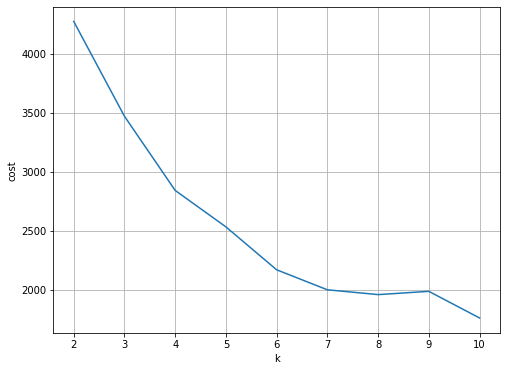

In [ ]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2, no_cluster + 1), cost[2:no_cluster + 1])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

In [ ]:
import time
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce 

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        # Take average
        silh_array=np.asanyarray(silh_val)
        print("k =", k, silh_array.mean())
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst, silh_lst)), columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table


In [ ]:
# Getting the optimal number of clusters by finding silhouette coefficients
# Input: dataset, indexed feature column name, min k, max k, number of runs
# Output: a list of silhouette scores from k = 2 to k = 10 by running each k value 1 time.

k, silh_lst, r_table = optimal_k(data, 'features', 2, 10, 1)

k = 2 0.6467839104258299
k = 3 0.45441774653511485
k = 4 0.4538511442568715
k = 5 0.41669941033286334
k = 6 0.3958697961862607
k = 7 0.41768551887008637
k = 8 0.4722452254056169
k = 9 0.4054416918069171
k = 10 0.44218122415108696
+------------------------------------------------------------+
|         The finding optimal k phase took       28 s.       |
+------------------------------------------------------------+


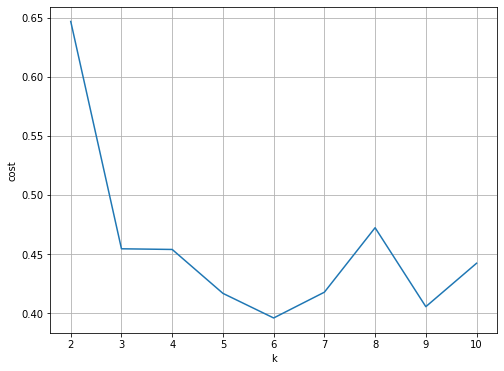

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2, no_cluster + 1), silh_lst.silhouette)
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(8) \
          .setFeaturesCol("features")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
# Get stage from transformer and K-Means
pipeline = Pipeline(stages=[numeric_assembler , kmeans])
pre_clustered_data = data.drop('numeric_vec')
model = pipeline.fit(pre_clustered_data)
clustered_data = model.transform(pre_clustered_data)

In [ ]:
clustered_data.show(10)

+------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+--------------------+--------------------+-------+
|  Area|BHK|Bathroom|    Furnishing|Parking|   Price|       Status| Transaction|         Type|Locality|price_category|            features|         numeric_vec|cluster|
+------+---+--------+--------------+-------+--------+-------------+------------+-------------+--------+--------------+--------------------+--------------------+-------+
| 800.0|  3|       2|Semi-Furnished|      1| 6500000|Ready_to_move|New_Property|Builder_Floor|  Rohini|           1.0|[0.83649497367323...|[800.0,3.0,2.0,1....|      3|
| 750.0|  2|       2|Semi-Furnished|      1| 5000000|Ready_to_move|New_Property|    Apartment|  Rohini|           0.0|[0.78421403781866...|[750.0,2.0,2.0,1....|      2|
| 950.0|  2|       2|     Furnished|      1|15500000|Ready_to_move|      Resale|    Apartment|  Rohini|           1.0|[0.99333778123697...|[950.0,2.0,2.0,1